# Episode-2

    0 : land_x 0, land_y 100
    1 : land_x 1000, land_y 500
    2 : land_x 1500, land_y 1500
    3 : land_x 3000, land_y 1000
    4 : land_x 4000, land_y 150
    5 : land_x 5500, land_y 150
    6 : land_x 6999, land_y 800
    

In [1]:
import numpy as np
from typing import List, Optional, Callable, Tuple, Dict, Union  # OneNote2021 #_python_ #_typing_
GENE = List[int]  # (rotate (-15 ~ +15),power (-1, 0, +1)) 避免無用的值域，下給 Web site 的 command 要轉換成 (rotate(-90 ~ +90), power(0,1,2,3,4))
GENOME = List[GENE]  # Genome 是一個 list 裡面都是 int
STATE = Dict[str,Union[int,float,np.array]]  # x,y,hspeed,power,.. etc 

# Get modules and peforth tools
import random, json, math, copy

from itertools import permutations  # permutations 數學「排列組合」中的「排列」
import peforth, IPython
peforth.bps = [i for i in range(100)]  # 預設有這麼多 Breakpoint ID
def bp(id=None,locals=None):
    # Breakpoint ID 不能超過 peforth.bps 保留，超過的無效。
    if id==None: 
        id = 0
        prompt='bp> '
    else:
        prompt="{}>".format(id)
    if id in peforth.bps: peforth.push(locals).ok(prompt, cmd="to _locals_")
peforth.bp = bp
peforth.push(bp).dictate("py: vm.bp=pop()")  # [ ] 忘了 vm.bp 有何用途？
peforth.dictate('''
    import IPython
    : paste py> IPython.lib.clipboard.win32_clipboard_get() tib.insert ;
        // ( ... -- ... ) 執行 clipboard 裡的內容，jupyternotebook 進了 peforth prompt 特別需要此功能。
    : path-to-find-modules ( <path> -- ) // Add path to sys.path so "import module-name" can find the module
        CR word trim ( "path" ) py: sys.path.append(pop()) ;

    \ ------ breakpoint ------------------------------------------------------------
    : bp ." Usage: peforth.bp(11,locals())  # drop a breakpoint with ID=11" cr ;
    : bl // ( -- ) List all breakpoints
        __main__ :> peforth.bps 
        <py>
        bps = pop()
        print('Disabled breakpoints:')
        for i in range(len(bps)):
            if not bps[i]: 
                print(i, end=' ')
        print(); print('Enabled breakpoints:')
        count = 0
        for i in range(len(bps)):
            if bps[i]: 
                print(i, end=' ')
                count += 1
        print(); print('Enabled breakpoints count: {}/{}'.format(count,len(bps)))
        </py> cr ;
        /// Breakpoint commands:
        ///	  bl  - list all breakpoints (capital BL is white space) 
        ///	  be  - enable breakpoints, e.g. be 1 2 3 
        ///	  bd  - disable breakpoints, e.g. bd 1 2 3 
        ///	  be* - enable all breakpoints
        ///	  bd* - disable all breakpoints 
        /// Also: 
        ///   for i in [11,22,33]: peforth.bps[i]=0	 # disable breakpoints 11,22,33 
        ///   for i in [11,22,33]: peforth.bps[i]=i	 # enable  breakpoints 11,22,33 
    
    : bd // ( <1 2 3 4...> -- ) Disable listed breakpoints 
        CR word ( line ) __main__ :> peforth.bps ( line bps )
        <py>
        line, bps = pop(1), pop(0)
        points = map(int, line.split(' '))
        for i in points: bps[i] = 0
        </py> ; 
        ' bl :> comment last :: comment=pop(1)
    
    : be // ( <1 2 3 4...> -- ) Enable listed breakpoints 
        CR word ( line ) __main__ :> peforth.bps ( line bps ) 
        <py>
        line, bps = pop(1), pop(0)
        points = map(int, line.split(' '))
        for i in points: bps[i] = i
        </py> ; 
        ' bl :> comment last :: comment=pop(1)
    
    : bd* // ( -- ) Disable all breakpoints 
        __main__ :> peforth.bps	 ( bps ) 
        <py>
        bps = pop()
        for i in range(len(bps)): bps[i] = 0
        </py> ;
        ' bl :> comment last :: comment=pop(1)
    
    : be* // ( -- ) Enable all breakpoints 
        __main__ :> peforth.bps	 ( bps ) 
        <py>
        bps = pop()
        for i in range(len(bps)): bps[i] = i
        </py> ;
        ' bl :> comment last :: comment=pop(1)
    \ ------ xstack ------------------------------------------------------------
    [] value xstack xstack py: vm.xstack=pop() // ( -- array ) The xstack. 掛進 vm 就可以直接以 py> xstack 取用。
    : x@ xstack :> [-1] ; // ( -- n ) Get TOS of the xstack
    : x> xstack :> pop() ; // ( -- n ) Pop the xstack
    : >x xstack :: append(pop()) ; // ( n -- ) Push n into the xstack
    : .sx xstack . ; // ( -- ) List xstack 
    : xdrop x> drop ; // ( X: ... a -- X: ... ) drop xstack 
    : xdropall [] to xstack ; // ( X: ... -- X: empty ) clear xstack 
    ''')
%f version drop


reDef unknown
reDef -->
p e f o r t h    v1.26
source code http://github.com/hcchengithub/peforth
Type 'peforth.ok()' to enter forth interpreter, 'exit' to come back.



# 直接讀 log 檔
So the `%store log` is from here

In [2]:
# Read back the json file which was saved by the above cell.
%f s" episode2-original.json" readTextFile py> eval(pop()) constant log // ( -- json ) "actual free fall.json" log from Codingame > Mars Lander > episode-1 
log = peforth.execute('log').pop()
%f log -->
%store log

log --> [{'step': 0, 'length': 73, 'x': 2500, 'y': 2700, 'hspeed': 0, 'vspeed': 0, 'fuel': 550, 'angle': 0, 'power': 0, 'cmd': [-99, -99]}, {'step': 1, 'length': 73, 'x': 2500, 'y': 2699, 'hspeed': 0, 'vspeed': -3, 'fuel': 549, 'angle': -15, 'power': 1, 'cmd': [-20, 3]}, {'step': 2, 'length': 73, 'x': 2501, 'y': 2695, 'hspeed': 1, 'vspeed': -5, 'fuel': 547, 'angle': -20, 'power': 2, 'cmd': [-20, 3]}, {'step': 3, 'length': 73, 'x': 2502, 'y': 2690, 'hspeed': 2, 'vspeed': -5, 'fuel': 544, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 4, 'length': 73, 'x': 2505, 'y': 2684, 'hspeed': 3, 'vspeed': -6, 'fuel': 541, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 5, 'length': 73, 'x': 2508, 'y': 2677, 'hspeed': 4, 'vspeed': -7, 'fuel': 538, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 6, 'length': 73, 'x': 2513, 'y': 2670, 'hspeed': 5, 'vspeed': -8, 'fuel': 535, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 7, 'length': 73, 'x': 2518, 'y': 2661, 'hspeed': 6, 'vspeed

In [2]:
# 最基本的定義 

Gravity = 3.711        # constant on Mars
G = Gravity             # 到了二維以上，重力需轉成向量
Altitude = 150          # altitude of the flat 
VSpeed = 40             # target virtical speed 
HSpeed = 20             # target horizental speed 
fuel0 = 550             # episode-2

# Parameters

round_off = 2           # 顯示到小數點以下兩位避免太長

In [3]:
class Vector:
    def __init__(self, x:float,y:float):
        self.x = x
        self.y = y

    def __mul__(self, x:float):
        m = self.v() * x 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 
    
    def __add__(self, x):
        m = self.v() + x.v() 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 

    def v(self) -> np.array:
        # A vector is a np.array
        return np.array([self.x,self.y])

    def n(self) -> float:
        # norm of a vector is its length
        return np.linalg.norm(self.v())

    def u(self) -> np.array:
        # Shrink the given vector into an unit vector. https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy
        return self if round(self.n(),6) == 0. else self.v()/self.n();  # 考慮周詳
    
    def __str__(self) -> str:
        return 'Vec' + str(np.array([round(self.x,round_off),round(self.y,round_off)]))
    
%f Vector :> (3,4) -->
%f Vector :> (3,4).v() -->
%f Vector :> (3,4).x -->
%f Vector :> (3,4).y -->
%f Vector :> (3,4).n() -->
%f Vector :> (3,4).u() -->
%f Vector :> (0.6,0.8).n() -->
%f Vector :> (0.6,0.8)*2 -->    

Vector :> (3,4) --> Vec[3 4] (<class '__main__.Vector'>)
Vector :> (3,4).v() --> [3 4] (<class 'numpy.ndarray'>)
Vector :> (3,4).x --> 3 (<class 'int'>)
Vector :> (3,4).y --> 4 (<class 'int'>)
Vector :> (3,4).n() --> 5.0 (<class 'numpy.float64'>)
Vector :> (3,4).u() --> [0.6 0.8] (<class 'numpy.ndarray'>)
Vector :> (0.6,0.8).n() --> 1.0 (<class 'numpy.float64'>)
Vector :> (0.6,0.8)*2 --> Vec[1.2 1.6] (<class '__main__.Vector'>)


In [4]:
class Angle(Vector):
    def __init__(self, an:float) -> Vector:
        # Convert the given absolute angle in degrees to a unit vector that represents the angle
        v = Vector(math.cos(np.deg2rad(an + 90)), math.sin(np.deg2rad(an + 90)))
        self.x, self.y = v.x, v.y  # 無須這樣 v.u()[0], v.u()[1]

%f Angle :> (-180) :> v() -->
%f Angle :> (-180) -->
%f Angle :> (90)   -->
%f Angle :> (-90)  -->   
%f Angle :> (180)  -->   
%f Angle :> (45)   -->   
%f Angle :> (-45)  -->   
%f Angle :> (-45) type -->   
    

Angle :> (-180) :> v() --> [ 6.123234e-17 -1.000000e+00] (<class 'numpy.ndarray'>)
Angle :> (-180) --> Vec[ 0. -1.] (<class '__main__.Angle'>)
Angle :> (90)   --> Vec[-1.  0.] (<class '__main__.Angle'>)
Angle :> (-90)  --> Vec[1. 0.] (<class '__main__.Angle'>)
Angle :> (180)  --> Vec[-0. -1.] (<class '__main__.Angle'>)
Angle :> (45)   --> Vec[-0.71  0.71] (<class '__main__.Angle'>)
Angle :> (-45)  --> Vec[0.71 0.71] (<class '__main__.Angle'>)
Angle :> (-45) type --> <class '__main__.Angle'> (<class 'type'>)


In [5]:
G = Angle(180) * Gravity  # G = Vector(*(Angle(180).v() * Gravity)) 我有提供 __mul__ 

%f G -->
%f G type --> 


G --> Vec[-0.   -3.71] (<class '__main__.Vector'>)
G type --> <class '__main__.Vector'> (<class 'type'>)


In [6]:
class State():

    def __init__(self, step=0, x=2500, y=2700, hspeed=0, vspeed=0, fuel=550, angle=0, power=0):
        self.step   = step
        self.x      = x
        self.y      = y
        self.hspeed = hspeed
        self.vspeed = vspeed
        self.fuel   = fuel
        self.angle  = angle
        self.power  = power
        # self.force  = G + Angle(self.angle)*self.power

    def next(self, angle:int, power:int):  
        # input angle,power 都是 offset differential delta 分別屬 -15~15 以及 -1,0,+1 
        assert power in [-1, 0, 1], 'expected input power [-1, 0, +1], given {}'.format(power)
        assert angle in range(-15,16), 'input angle range [-15:16], given {}'.format(angle)
        self.step   += 1
        self.angle  += angle
        self.angle   = -90 if self.angle < -90 else self.angle
        self.angle   =  90 if self.angle > 90 else self.angle
        self.power  += power
        self.power   = 0 if self.power < 0 else self.power
        self.power   = 4 if self.power > 4 else self.power
        self.fuel   -= self.power
     #  self.x       = self.x       # episode-1 不變
     #  self.y       = self.y + self.vspeed + (1/2)*self.force
     #  self.hspeed  = self.hspeed  # episode-1 不變
     #  self.vspeed += self.force
        bp(1,locals())
        force = G + Angle(self.angle)*self.power  # force on the ship during this step         
        bp(2,locals())
        s0 = Vector(self.hspeed,self.vspeed)
        p0 = Vector(self.x,self.y)
        bp(3,locals())
        s1 = s0 + force 
        bp(4,locals())
        p1 = p0 + s0 + force*0.5
        bp(5,locals())
        self.x, self.y = p1.x, p1.y
        bp(6,locals())
        self.hspeed, self.vspeed = s1.x, s1.y
        bp(7,locals())

        return self  # 傳回值只是方便測試，可以這樣寫： %f state :> next(0,3.711) -->

    def __str__(self):  
        d = copy.deepcopy(self.__dict__)
        return str([{k:int(round(v,0))} for k,v in d.items()])

state0 = State(0,2500,2700,0,0,fuel0,0,0)  # episode-2 的起點 state

In [7]:
%f bd*
state = State(**state0.__dict__)
%f state :> next(-15,1) -->
%f state :> next(-5,1) -->
%f state :> next(0,1) -->
for i in range(50):
    state.next(0,0)
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->
%f state :> next(0,0) -->


state :> next(-15,1) --> [{'step': 1}, {'x': 2500}, {'y': 2699}, {'hspeed': 0}, {'vspeed': -3}, {'fuel': 549}, {'angle': -15}, {'power': 1}] (<class '__main__.State'>)
state :> next(-5,1) --> [{'step': 2}, {'x': 2501}, {'y': 2695}, {'hspeed': 1}, {'vspeed': -5}, {'fuel': 547}, {'angle': -20}, {'power': 2}] (<class '__main__.State'>)
state :> next(0,1) --> [{'step': 3}, {'x': 2502}, {'y': 2690}, {'hspeed': 2}, {'vspeed': -5}, {'fuel': 544}, {'angle': -20}, {'power': 3}] (<class '__main__.State'>)
state :> next(0,0) --> [{'step': 54}, {'x': 3937}, {'y': 1251}, {'hspeed': 54}, {'vspeed': -51}, {'fuel': 391}, {'angle': -20}, {'power': 3}] (<class '__main__.State'>)
state :> next(0,0) --> [{'step': 55}, {'x': 3992}, {'y': 1200}, {'hspeed': 55}, {'vspeed': -52}, {'fuel': 388}, {'angle': -20}, {'power': 3}] (<class '__main__.State'>)
state :> next(0,0) --> [{'step': 56}, {'x': 4048}, {'y': 1147}, {'hspeed': 56}, {'vspeed': -53}, {'fuel': 385}, {'angle': -20}, {'power': 3}] (<class '__main__.S

In [ ]:
assert False

In [22]:
# 全部下 -20,3 取 trace 
trace = np.array
state = State(**state0.__dict__)  # init for ecah genome 
trace.append([state.x,state.y])
%f state :> next(-15,1) -->
trace.append([state.x,state.y])
%f state :> next(-5,1) -->
trace.append([state.x,state.y])
%f state :> next(0,1) -->
trace.append([state.x,state.y])
for i in range(70):
    %f state :> next(0,0) -->
    trace.append([state.x,state.y])
%f trace -->

AttributeError: 'builtin_function_or_method' object has no attribute 'append'

In [21]:
trace.reshape(-1,1)

AttributeError: 'list' object has no attribute 'reshape'

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


ValueError: x and y must have same first dimension, but have shapes (73,) and (1,)

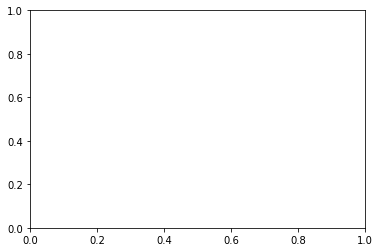

In [43]:
%pylab 
%matplotlib inline 
x = [0, 1000, 1500, 3000, 4000, 5500, 6999]
y = [100, 500, 1500, 1000, 150, 150, 800]
# plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k') 
plt.plot(x,y,'',range(73),trace,'rx');


In [ ]:
for i in range(9):
    state.next(0,0);
    sample_genomes["安全降落"].append([0,0])
for i in range(9,91):
    state.next(0,1);
    sample_genomes["安全降落"].append([0,1])
state_list["安全降落"]=state

In [ ]:
# 改寫 for Mars Lander 乍看以為要頭痛一會兒，其實 Mars Lander 的 genome 很簡單，就是一串 (int,int) 
# pairs 而已。前面基礎討論有提到，以 SA 而言就是 mutate 某一個 gene 也就是 command pair 而已。但是考慮 Mars
# Lander 的限制條件，以 epidode-1 而言，command 的改變要做的決定是 -1 0 +1 其中之一才對，而非 0~4. 

# 長度的問題，
# 太長而無效的 genes 要 cut 掉。
# 長度不夠時直接 copy 最後一個 gene 頂替即可。
# 會發現 genome 太長或不夠的是 simulator 那就是由它處理。

# 1. 避免無效的 neighbour 例如前一 power 是 0 或 4 卻下 -1 或 1 就是無效的，這個 neighbour 就浪費了。 
# 2. 第一個 gene 的 power 不能下 -1 只能下 0 或 +1 , 將來 angle 也有一樣的限制。

def get_random_neighbour(genome: GENOME) -> None :
    neighbour = copy.deepcopy(genome)  # 利用 [:] slice copy 不行！
    commands = genome_to_command_list(neighbour)  # 絕對 command, 用來檢查前一狀態避免產生無效的 neighbour 
    
    while True:  # 試到不一樣了才出來
        idx = random.randint(0,len(genome)-1) # 選 1 個 gene 
        cmd = random.randint(-1, 1)  # -1, 0, +1 當中選 1 個 thrust command (episode-1)
        if idx == 0 and cmd == -1 : continue  # 一開始的 power 就是 0 再下 -1 無效
        if idx >= 1 and cmd == -1 and commands[idx-1][1] == 0: continue  # 前一個 power 就已經是 0 又下 -1 無效
        if idx >= 1 and cmd ==  1 and commands[idx-1][1] == 4: continue  # 前一個 power 就已經是 4 又下 +1 無效
        if neighbour[idx][1] == cmd: continue  # 沒有變化當然無效
        else: 
            neighbour[idx][1] = cmd
            break
            
    return neighbour
%f get_random_neighbour :> ([[0,0],[0,0]]) ( 都不可能出現 -1 ) -->    
%f get_random_neighbour :> ([[0,0],[0,1]]) ( 都不可能出現 -1 ) -->    
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
                             

# Original sample code

#### Surface landscape
    <pre class="stderr" ng-if="::subframe.stderr" ng-bind-html="::subframe.stderr | secureOutput | promptOutput | trustHtml">
    <div class="outputLine">i 0 : land_x 0, land_y 100</div>
    <div class="outputLine">i 1 : land_x 1000, land_y 500</div>
    <div class="outputLine">i 2 : land_x 1500, land_y 1500</div>
    <div class="outputLine">i 3 : land_x 3000, land_y 1000</div>
    <div class="outputLine">i 4 : land_x 4000, land_y 150</div>  取 5000,150 當作目標
    <div class="outputLine">i 5 : land_x 5500, land_y 150</div>
    <div class="outputLine">i 6 : land_x 6999, land_y 800</div>


In [ ]:
import sys
import math

# Auto-generated code below aims at helping you parse
# the standard input according to the problem statement.

surface_n = int(input())  # the number of points used to draw the surface of Mars.
for i in range(surface_n):
    # land_x: X coordinate of a surface point. (0 to 6999)
    # land_y: Y coordinate of a surface point. By linking all the points together in a sequential fashion, you form the surface of Mars.
    land_x, land_y = [int(j) for j in input().split()]
    print('i {} : land_x {}, land_y {}'.format(i, land_x, land_y), file=sys.stderr, flush=True)

# game loop
while True:
    # h_speed: the horizontal speed (in m/s), can be negative.
    # v_speed: the vertical speed (in m/s), can be negative.
    # fuel: the quantity of remaining fuel in liters.
    # rotate: the rotation angle in degrees (-90 to 90).
    # power: the thrust power (0 to 4).
    x, y, h_speed, v_speed, fuel, rotate, power = [int(i) for i in input().split()]

    # Write an action using print
    # To debug: print("Debug messages...", file=sys.stderr, flush=True)


    # rotate power. rotate is the desired rotation angle. power is the desired thrust power.
    print("-20 3")


In [ ]:
def combi(r, n):
    return 1 if n == 0 else combi(r, n - 1) * (r - n + 1) // n
	
height = 13
c = [[combi(r, n) for n in range(r + 1)] for r in range(height)]
 
for r in range(len(c)):
    print(("%" + str((len(c) - r) * 3) + "s") % "", end = "")
    for n in range(len(c[r])):
	    print("%6d" % c[r][n], end = "");
    print()